# Allora Forge ML Workflow

This notebook with help you get started submitting inferences to the Allora network and take part in the Forge competition.

## In this notebook you will quickly be able to:

  1. Load training and validation data.
  2. Load a LightGBM model
  3. Train the model
  4. Evaluate the model on validation data (recent 6 months)
  5. Package your predict function into a `.pkl` file
  6. (TODO: Run your worker to deliver inference to the network)

## What you will need

  1. Allora Data API Key
  2. (Allora Network Wallet Address for live predictions) - under construction
  3. (Forge Competition Topic ID for live predictions) - under construction



In [2]:
'''
Write Imports
'''

from allora_ml_workflow import AlloraMLWorkflow #Allora Forge
import lightgbm as lgb
import pandas as pd
import dill
import time
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
'''
API KEY (this will be provided by Allora)
This gives you access to OHLCV (open, high, low, close, volume) candle data through the workflow

'''

api_key = "<your allora api key here>"

In [4]:
'''
Setup

These variables define the ticker data to retrieve, and the feature and targets sizes.

hours_needed: 
'''
tickers = ["btcusd", "ethusd", "solusd"]
hours_needed = 1*24             # Number of historical hours for feature lookback window
number_of_input_candles = 24    # Number of candles for input features
target_length = 1*24            # Number of hours into the future for target

# Instantiate the workflow
workflow = AlloraMLWorkflow(
    data_api_key=api_key,
    tickers=tickers,
    hours_needed=hours_needed,
    number_of_input_candles=number_of_input_candles,
    target_length=target_length
)

In [5]:
# Get training, validation, and test data
X_train, y_train, X_val, y_val, X_test, y_test = workflow.get_train_validation_test_data(
    from_month="2023-01",
    validation_months=3,
    test_months=3
)

# Example: Check the shapes of the datasets
print("Training set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)
print("Test set:", X_test.shape, y_test.shape)

Processing 5-minute bars for btcusd
Computing target
Extracting features
Processing 5-minute bars for ethusd
Computing target
Extracting features
Processing 5-minute bars for solusd
Computing target
Extracting features
Training set: (654596, 151) (654596,)
Validation set: (74682, 151) (74682,)
Test set: (78621, 151) (78621,)


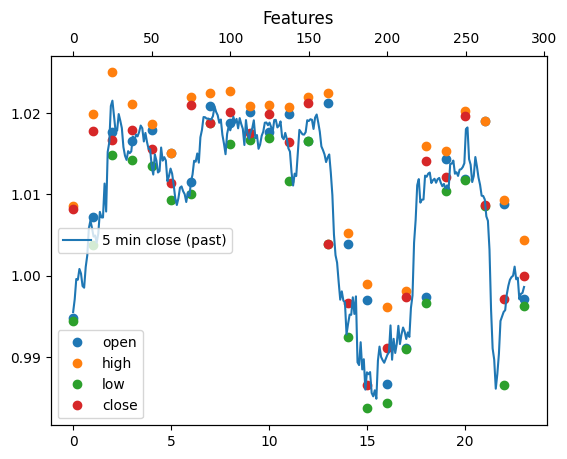

In [7]:
'''
Visualize Features and Past Price Process

The Features are the input data used for training the model, 
while the Past Price Process shows the historical price movements of the asset.

Currently, the features are just the normalized OHLCV (open, high, low, close, volume) data for the last 24 hours.
However, you can choose a different history length by changing the `hours_needed` variable above, 
or the number of candles by changing `number_of_input_candles`.

'''

eth_data = X_train.loc[(slice(None), 'ethusd'), :]
data_idx = -10000  # which data point to visualize

# Plot features based on data_idx
plt.plot([eth_data.iloc[data_idx][f"feature_open_{i}"] for i in range(number_of_input_candles)], 'o', label="open")
plt.plot([eth_data.iloc[data_idx][f"feature_high_{i}"] for i in range(number_of_input_candles)], 'o', label="high")
plt.plot([eth_data.iloc[data_idx][f"feature_low_{i}"] for i in range(number_of_input_candles)], 'o', label="low")
plt.plot([eth_data.iloc[data_idx][f"feature_close_{i}"] for i in range(number_of_input_candles)], 'o', label="close")
plt.legend()

# Plot past price process based on data_idx
plt.twiny()
plt.plot(
    (eth_data.iloc[data_idx - (hours_needed * 12):data_idx]['close'].values) / eth_data.iloc[data_idx]['close'],
    label="5 min close (past)"
)
plt.legend(loc='center left')
plt.title("Features")
plt.show()

In [ ]:
'''
"Hello World!" ML Model
This is a simple LightGBM model that predicts the future price of an asset based on its past price process,
as given by the features.

The validation set is used to tune the model, and the test set is used to evaluate its performance.

In this case, the validation set is used for early stopping, which helps prevent overfitting.

Then the model is retrained on the combined training and validation data using the best iteration found during training,
before evaluating on the test set.
'''


#define feature columns and ML model
feature_cols = [f for f in list(X_train) if 'feature' in f]

#define hyperparameters for the LightGBM model
learning_rate = 0.001
max_depth = 5
num_leaves = 8

# Initialize LightGBM model with hyperparameters
model = lgb.LGBMRegressor(
    n_estimators=1000,  # Set a high number of estimators for early stopping
    learning_rate=learning_rate,
    max_depth=max_depth,
    num_leaves=num_leaves
)

# Define custom evaluation metric for correlation
def corr_eval_metric(y_true, y_pred):
    corr = np.corrcoef(y_true, y_pred)[0, 1]
    # LightGBM expects: (eval_name, eval_result, is_higher_better)
    return 'corr', corr, True

# Fit model with early stopping
model.fit(
    X_train[feature_cols], y_train,
    eval_set=[(X_val[feature_cols], y_val)],
    eval_metric=corr_eval_metric,
    callbacks=[
        lgb.early_stopping(stopping_rounds=100, verbose=True),
        lgb.log_evaluation(period=10)
    ]
)
best_iteration = model.best_iteration_

#retrain the model to best iteration on train + validation data
model = lgb.LGBMRegressor(
    n_estimators=best_iteration,  # Use the optimal number of trees
    learning_rate=learning_rate,
    max_depth=max_depth,
    num_leaves=num_leaves
)
model.fit(
    pd.concat([X_train[feature_cols], X_val[feature_cols]]), 
    pd.concat([y_train, y_val])
)
# Evaluate
#  on the test data
test_preds = model.predict(X_test[feature_cols])
test_preds = pd.Series(test_preds, index=X_test.index)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.088933 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36465
[LightGBM] [Info] Number of data points in the train set: 654596, number of used features: 143
[LightGBM] [Info] Start training from score 0.002390
Training until validation scores don't improve for 100 rounds
[10]	valid_0's l2: 0.00147836	valid_0's corr: 0.125338
[20]	valid_0's l2: 0.00147787	valid_0's corr: 0.125408
[30]	valid_0's l2: 0.00147738	valid_0's corr: 0.12629
[40]	valid_0's l2: 0.00147691	valid_0's corr: 0.125932
[50]	valid_0's l2: 0.00147643	valid_0's corr: 0.126154
[60]	valid_0's l2: 0.00147598	valid_0's corr: 0.125813
[70]	valid_0's l2: 0.00147553	valid_0's corr: 0.125624
[80]	valid_0's l2: 0.00147509	valid_0's corr: 0.125829
[90]	valid_0's l2: 0.00147469	valid_0's corr: 0.125584
[100]	valid_0's l2: 0.0014743	valid_0's corr: 0.125408
[110]	valid_0's l2: 0.00147394	valid_0's cor

In [27]:
'''
The Workflow has a built-in method to evaluate the test data predictions.
'''

#show test metrics
metrics = workflow.evaluate_test_data(test_preds)
print(metrics)

{'correlation': 0.038930690096235177, 'directional_accuracy': 0.5414329504839673}


In [28]:
'''
The model is finally re-trained on the entire dataset, including the test data,
before it is packaged into a pickled function for live predictions.
'''

model.fit(
    pd.concat([X_train[feature_cols], X_val[feature_cols], X_test[feature_cols]]), 
    pd.concat([y_train, y_val, y_test])
)


# Final predict function
def predict() -> pd.Series:
    live_features = workflow.get_live_features("btcusd")
    preds = model.predict(live_features)
    return pd.Series(preds, index=live_features.index)

# Pickle the function
with open("predict.pkl", "wb") as f:
    dill.dump(predict, f)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.152397 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36465
[LightGBM] [Info] Number of data points in the train set: 807899, number of used features: 143
[LightGBM] [Info] Start training from score 0.002232


In [29]:
'''
Test Live Predictions

This function simulates a live prediction scenario by loading the pickled function,
calling it, and printing the prediction time and result.
'''

# Load the pickled predict function
with open("predict.pkl", "rb") as f:
    predict_fn = dill.load(f)

# Call the function and get predictions
tic = time.time()
prediction = predict_fn()
toc = time.time()

print("predict time: ", (toc - tic) )
print("prediction: ", prediction )


predict time:  0.49544739723205566
prediction:  2025-08-05 17:15:00+00:00    0.002185
dtype: float64
